In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("coco-2017", split="validation", max_samples=1000)

Found annotations at '/home/dan/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 1000/1000 [2.1s elapsed, 0s remaining, 459.5 samples/s]      
Dataset 'coco-2017-validation-1000' created


In [2]:
import fiftyone.utils.iou as foui

foui.compute_max_ious(dataset, "ground_truth", iou_attr="max_iou", classwise=True)
print("Max IoU range: (%f, %f)" % dataset.bounds("ground_truth.detections.max_iou"))

 100% |███████████████| 1000/1000 [1.0s elapsed, 0s remaining, 995.5 samples/s]         
Max IoU range: (0.000000, 0.951640)


In [3]:
from fiftyone import ViewField as F

# Retrieve detections that overlap above a chosen threshold
dups_view = dataset.filter_labels("ground_truth", F("max_iou") > 0.75)
print(dups_view)

Dataset:     coco-2017-validation-1000
Media type:  image
Num samples: 7
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. FilterLabels(field='ground_truth', filter={'$gt': ['$$this.max_iou', 0.75]}, only_matches=True, trajectories=False)



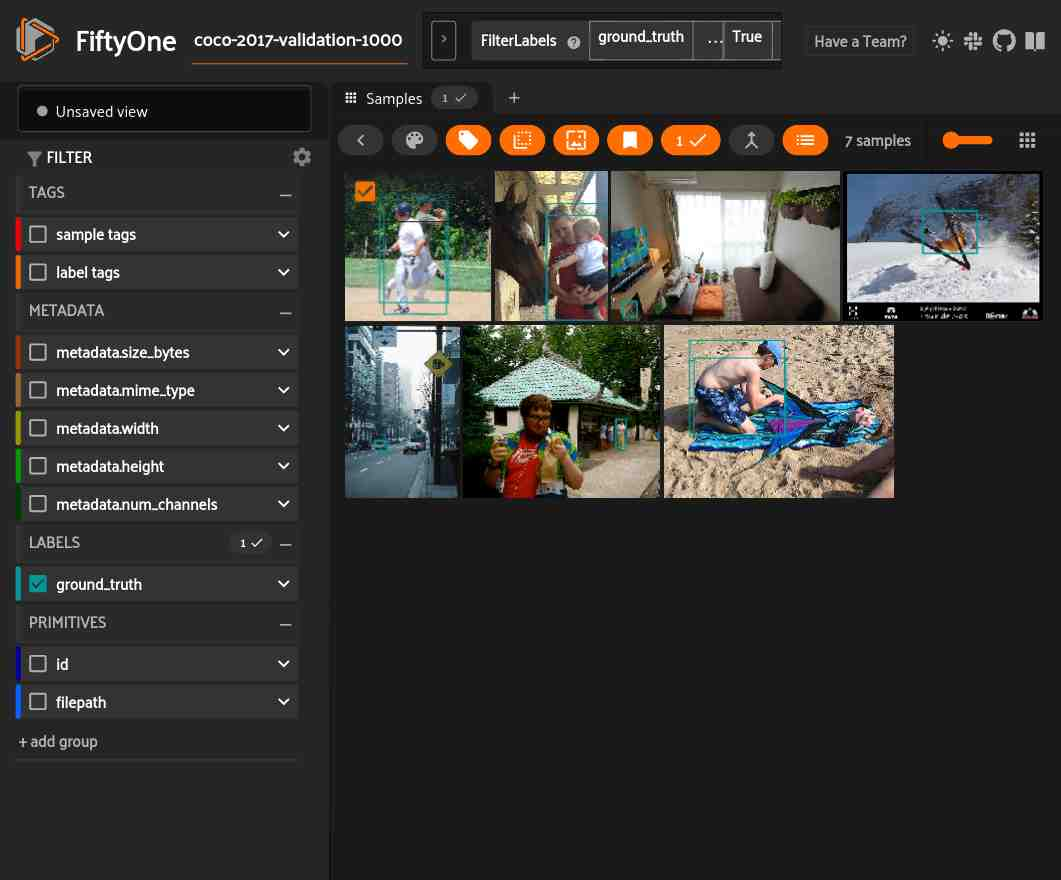

In [4]:
session = fo.launch_app(view=dups_view)